# Sampling using the TSM objective


In [1]:
!pip install --q diffrax
%pylab inline
import jax
from jax import numpy as jnp, random as jr, jit, grad, vmap
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 5.9 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


## Step I: Create a stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\qed}{\tag*{$\square$}}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 = \beta_1 = 0$ and $\alpha_1 = \beta_0 = 1$. Then $$\pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) = x_t \sim \pp_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving, $\beta_t^2 = 1-\alpha_t^2$, which implies $f_t(x) = \frac{\dot \alpha_t}{\alpha_t}x = \frac{g_t^2}{2}x$  
	  Typically $g_t^2 = t g_m^2 + (1-t) g_M^2$, then $\alpha_t = \exp((g_m^2(t^2-1) - g_M^2(1-t)^2)/4)$
	* Variance Exploding, $\alpha_t = 1$, which implies $f_t(x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$  
	  Typically $\beta_t = \beta_m^t \beta_M^{1-t}$, then $g_t^2 = 2\beta^2 \log\left(\frac{\beta_M}{\beta_m}\right)$
	* Optimal Transport, $\alpha_t = t = 1 - \beta_t$, which implies $f_t(x) = \frac{x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$

In [2]:
# Defining noise scheduling
def alpha_OT(t):
    return t

def beta_OT(t):
    return 1 - t

def alpha_VP(t, g2min=0.1, g2max=20):
    """https://huggingface.co/docs/diffusers/v0.13.0/en/api/schedulers/score_sde_vp"""
    return jnp.exp((g2min * (t**2 - 1) - g2max * (1 - t)**2) / 4)

def beta_VP(t, g2min=0.1, g2max=20.):
    alpha = alpha_VP(t, g2min, g2max)
    return (1 - alpha**2)**.5

def alpha_VE(t):
    return 1.

def beta_VE(t, betamin=0.01, betamax=100.):
    """https://huggingface.co/docs/diffusers/v0.13.0/en/api/schedulers/score_sde_ve"""
    return betamin**t * betamax**(1 - t)

# Current scheduling
alpha = alpha_VP
beta = beta_VP
drift = lambda t, y, args: grad(alpha)(t) / alpha(t) * y
diffusion = lambda t, y, args: (- alpha(t)**2 * grad(lambda t: (beta(t) / alpha(t))**2)(t))**.5 * jnp.ones_like(y)
# drift = lambda t, y, args: y / t
# diffusion = lambda t, y, args: (2 * (1 / t - 1))**.5 * jnp.ones_like(y)

In [8]:
def make_dist(alpha=1., beta=0., d=2, sigma0=1., probs=[0.5, 0.5]):
  """
  Returns a mixture of two d-dimensional Multivariate Gaussians.

  Args:
    d: The dimension of the Gaussian distributions.
    probs: The probabilities for the categorical distribution.
    alpha: The scaling factor for the mean of the Gaussians.
    beta: The standard deviation of the noise convolved with the Gaussians.
  """
  return tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=probs),
      components_distribution=tfd.MultivariateNormalDiag(
          loc=jnp.stack([-alpha * jnp.ones(d), alpha * jnp.ones(d)]),
          scale_diag=jnp.ones([2, d]) * ((alpha * sigma0)**2 + beta**2)**.5)
  )

def make_path(t=1, d=2, sigma0=1., probs=[0.5, 0.5]):
  """
  Returns a mixture of two d-dimensional Multivariate Gaussians.
  """
  return make_dist(alpha=alpha(t), beta=beta(t), d=d, sigma0=sigma0, probs=probs)

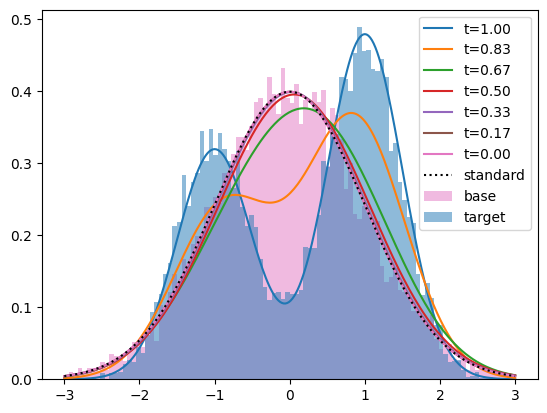

In [9]:
d = 1
sigma0 = 0.5
probs=[0.4, 0.6]
make_path = partial(make_path, d=d, sigma0=sigma0, probs=probs)
base = make_path(0.)
target = make_path(1.)
n_samples = 10000
base_samples = base.sample(n_samples, jr.key(0))
target_samples = target.sample(n_samples, jr.key(1))

xlim = (-3,3)
xlin = jnp.linspace(*xlim, 256)[...,None]
tlin = jnp.linspace(0, 1, 7)[::-1]

for t in tlin:
    dist_t = make_path(t)
    plot(xlin, dist_t.prob(xlin), label=f't={t:.2f}');
plot(xlin, tfd.Normal(loc=0., scale=1.).prob(xlin), ':k', label='standard');
hist(base_samples, 100, range=xlim, label='base', color=f'C{len(tlin)-1}', density=True,alpha=0.5);
hist(target_samples, 100, range=xlim, label='target', color='C0', density=True, alpha=0.5);
legend();

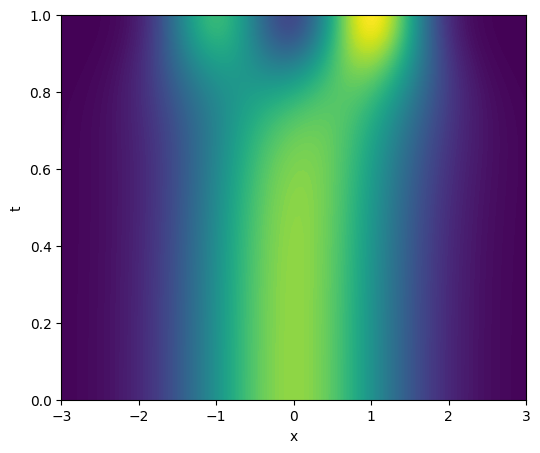

In [10]:
# We can visualize this in 2D
n_discr = 128
xx, tt = jnp.meshgrid(jnp.linspace(*xlim, n_discr), jnp.linspace(0, 1, n_discr))

# Reshape for vmap
xt = jnp.stack([tt.flatten(), xx.flatten()], axis=1)
def prob_at_tx(tx):
    t, x = tx
    dist_t = make_path(t)
    return dist_t.prob(x[...,None]).squeeze()
probabilities = vmap(prob_at_tx)(xt).reshape(n_discr, n_discr)

# Plot the contour
figure(figsize=(6, 5))
contourf(xx, tt, probabilities, 128)
xlabel('x'), ylabel('t');

Let's try to verify that our integration time is going to be rougly good enough, by running an SDE forward for time T with samples from the target distribution and verifying that we get a distribution similar to base.

In [36]:
def backward_sde(key, x):
  eps = 1e-6
  t0, t1 = eps, 1-eps
  back_drift = lambda t, y, args: -drift(t1 - t, y, args)
  back_diffusion = lambda t, y, args: diffusion(t1 - t, y, args)
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
  terms = MultiTerm(ODETerm(back_drift), ControlTerm(back_diffusion, brownian_motion))
  solver = Euler()
  saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.001, y0=x, saveat=saveat)
  return sol.ts[::-1], sol.ys

def forward_sde(key, x, score=lambda t, y, args: jnp.zeros_like(y)):
  eps = 1e-6
  t0, t1 = eps, 1-eps
  forw_drift = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 * score(t, y, args)
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
  terms = MultiTerm(ODETerm(forw_drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()
  saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.001, y0=x, saveat=saveat)
  return sol.ts, sol.ys

def flow_ode(key, x, score=lambda t, y, args: jnp.zeros_like(y)):
  eps = 1e-6
  t0, t1 = eps, 1-eps
  vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * score(t, y, args)
  terms = ODETerm(vf)
  solver = Euler()
  saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.001, y0=x, saveat=saveat)
  return sol.ts, sol.ys

In [37]:
keys = jr.split(jr.key(0), n_samples)
ts_back, xs_back = jit(vmap(backward_sde))(keys, target_samples)

score_target = lambda t, y, args: grad(make_path(t).log_prob)(y)
forward_sde_target = jit(vmap(partial(forward_sde, score=score_target)))
ts_forw, xs_forw = forward_sde_target(keys, base_samples)

flow_ode_target = jit(vmap(partial(flow_ode, score=score_target)))
ts_flow, xs_flow = flow_ode_target(keys, base_samples)

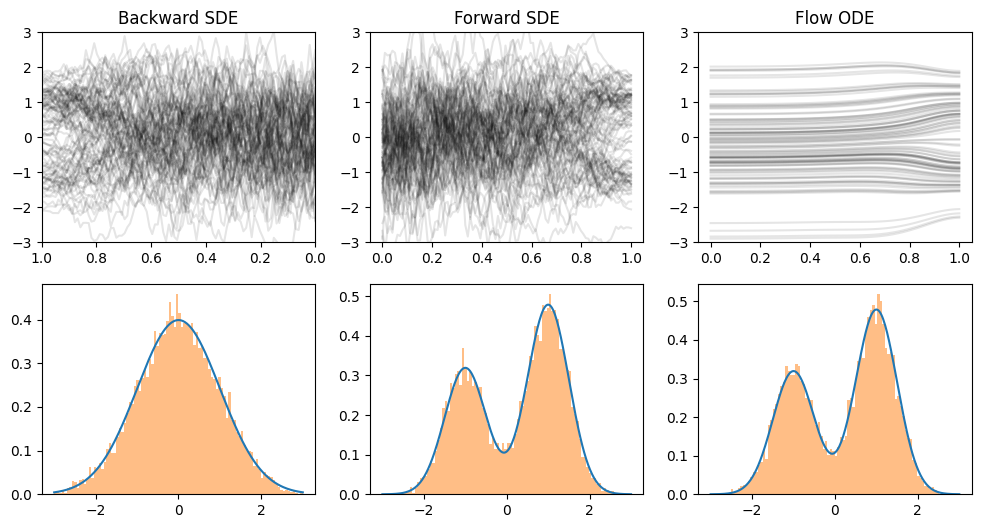

In [41]:
# Let's take a look at the trajectories
figure(figsize=(12,6))
subplot(231)
for i in range(100):
  plot(ts_back[i], xs_back[i], 'k', alpha=0.1);
plt.ylim(xlim), plt.xlim(1.,0.)
plt.title('Backward SDE')

subplot(232)
for i in range(100):
  plot(ts_forw[i], xs_forw[i], 'k', alpha=0.1);
plt.ylim(xlim)
plt.title('Forward SDE')

subplot(233)
for i in range(100):
  plot(ts_flow[i], xs_flow[i], 'k', alpha=0.1);
plt.ylim(xlim)
plt.title('Flow ODE')

subplot(234)
plot(xlin, base.prob(xlin));
hist(xs_back[:,-1], 100, range=xlim, density=True, alpha=0.5);

subplot(235)
plot(xlin, target.prob(xlin));
hist(xs_forw[:,-1], 100, range=xlim, density=True, alpha=0.5);

subplot(236)
plot(xlin, target.prob(xlin));
hist(xs_flow[:,-1], 100, range=xlim, density=True, alpha=0.5);

## Step II: Defining the score network and SDE

In [60]:
import flax.linen as nn

class ScoreNN(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        # Encoding time
        freqs = (jnp.arange(10)+1)*np.pi
        t = freqs * jnp.atleast_1d(t)
        t = jnp.concatenate([jnp.sin(t), jnp.cos(t)],axis=-1)
        # Building network
        x = jnp.concatenate([jnp.atleast_1d(x), t])
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=d)(x)
        return x

score = ScoreNN()
params = score.init(jr.key(0), jnp.zeros(d), jnp.zeros(1))

@jax.jit
@partial(vmap, in_axes=(0, None))
def sample_sde(key, params):
    key_x0, key_sde = jr.split(key)
    x0 = base.sample(seed=key_x0)
    return forward_sde(key_sde, x0, lambda t, y, args: score.apply(params, y, t))
    # return forward_sde(key_sde, x0, score_target)

In [63]:
# Let's sample from the untrained process
ts, xs = sample_sde(jr.split(jr.key(0), 1000), params)
print(ts.shape, xs.shape)

(1000, 100) (1000, 100, 1)


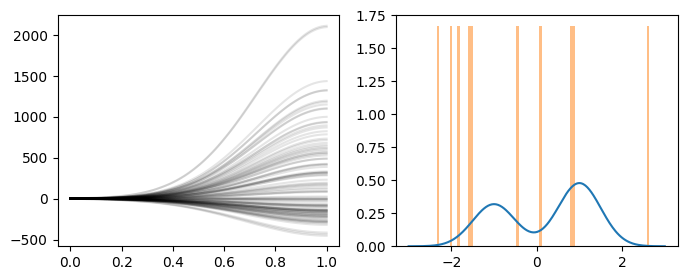

In [62]:
figure(figsize=(8,3))
subplot(121)
for i in range(100):
  plot(ts[i], xs[i], 'k', alpha=0.1);

subplot(122)
plot(xlin, target.prob(xlin));
hist(xs[:,-1], 100, range=xlim, density=True, alpha=0.5);

In [ ]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

@jax.jit
@partial(jax.vmap, in_axes=(None, 0))
def compute_probability(params, x):
  # Let's use the formula log p_t(x) = log p_0(x_0) + \int_0^t div(score(X_s, s)) ds
  # where X_s is the solution of dX_s = score(X_s, s) ds starting from x at time t and going backward to 0.
  t_start, t_end = 0, T

  def probability_flow_drift(t, y, args):
      x_val, log_p_val = y
      current_score = score.apply(args[0], jnp.atleast_1d(x_val), t).squeeze()
      drift_x = current_score
      drift_log_p = jax.grad(lambda params, x, t: score.apply(params, jnp.atleast_1d(x), t).squeeze(), argnums=1)(args[0], x_val, t)
      return drift_x, drift_log_p

  terms = ODETerm(probability_flow_drift)
  solver = Euler()
  saveat = SaveAt(ts=[0])
  y0 = (x, 0.0) # Initial log_p is 0, we add log p_0(x_0) later.

  sol = diffeqsolve(terms, solver, t_start, t_end, dt0=0.05, y0=y0, args=(params,), saveat=saveat)
  # The output sol.ys will be a tuple of arrays when y0 is a tuple.
  # Each array in the tuple corresponds to a component of y0, and contains the values at the saved time points.
  # Since we are saving at a single time point (time 0), each array will have shape (1,).
  x_0_array, integral_div_score_array = sol.ys
  x_0 = x_0_array[0]
  integral_div_score = integral_div_score_array[0]

  log_p_0_x_0 = base.log_prob(x_0)

  return log_p_0_x_0 + integral_div_score

In [ ]:
@jax.jit
def fn(x):
  return jax.vmap(jax.grad(target.log_prob))(x)

def loss_fn(params, t, y, s, w):
  return jnp.mean(  w/jnp.mean(w) * (jax.vmap(score.apply, in_axes=(None, 0, 0))(params, y, t) - s)**2)

In [ ]:
import optax

# Define the optimizer
optimizer = optax.adam(learning_rate=1e-3)

# Initialize the optimizer state
optimizer_state = optimizer.init(params)

# Define the training step
@jax.jit
def train_step(params, optimizer_state, t, y, s, w):
    loss, grads = jax.value_and_grad(loss_fn)(params, t, y, s, w)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, params)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

# Training loop
batch_size = 1024
key = jax.random.PRNGKey(0)

losses = []

Epoch 0, Loss: 80.1658935546875
Epoch 10, Loss: 65.36994934082031
Epoch 20, Loss: 66.72303009033203
Epoch 30, Loss: 54.50110626220703
Epoch 40, Loss: 56.48236846923828
Epoch 50, Loss: 52.4732780456543
Epoch 60, Loss: 49.94120407104492
Epoch 70, Loss: 47.34421920776367
Epoch 80, Loss: 47.840328216552734
Epoch 90, Loss: 46.05952072143555
Epoch 100, Loss: 51.572086334228516
Epoch 110, Loss: 50.27569580078125
Epoch 120, Loss: 51.95936584472656
Epoch 130, Loss: 51.657325744628906
Epoch 140, Loss: 47.620826721191406
Epoch 150, Loss: 49.4185791015625
Epoch 160, Loss: 48.1578483581543
Epoch 170, Loss: 48.17338562011719
Epoch 180, Loss: 49.854766845703125
Epoch 190, Loss: 48.1634521484375


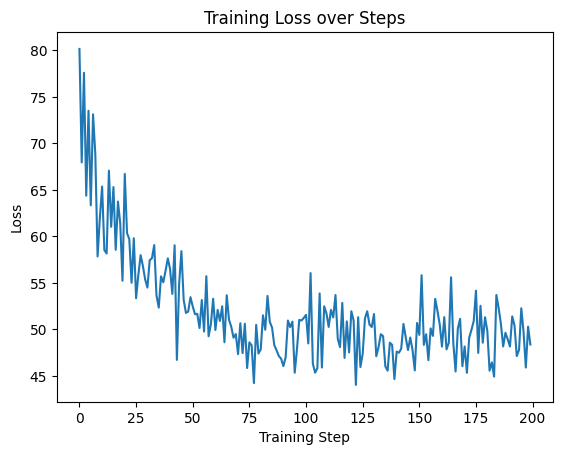

In [ ]:
for epoch in range(200):
  key, key_samples, key_t, key_x_t = jax.random.split(key, 4)

  # Sample a batch of trajectories from the forward process
  ts, Xs = reverse_process(jax.random.split(key_samples,batch_size), params)

  X_1 = Xs[:,0]
  ts = ts[:,:-1]
  # Reshape X_1 to match the shape of X_t before adding
  X_1 = jnp.repeat(X_1[:, None], ts.shape[1], axis=1)
  X_t = X_1 + jnp.sqrt(T-ts) * jax.random.normal(key_x_t, shape=ts.shape)

  # Flatten X_1, X_t, and ts
  X_1 = X_1.flatten()
  X_t = X_t.flatten()
  ts = ts.flatten()

  w = target.log_prob(X_1) - compute_probability(params, X_1)
  w = jnp.exp(w - jnp.max(w))
  w = w / jnp.sum(w)

  # Compute the score of the energy function
  scores = fn(X_1)

  params, optimizer_state, loss = train_step(params, optimizer_state, ts, X_t, scores, w)
  losses.append(loss)

  if epoch % 10 == 0:
    print(f'Epoch {epoch}, Loss: {loss}')

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

In [ ]:
# Let's try to draw from the process now
ts, samples = reverse_process(jax.random.split(jax.random.PRNGKey(0),10000), params)

(-5.0, 5.0)

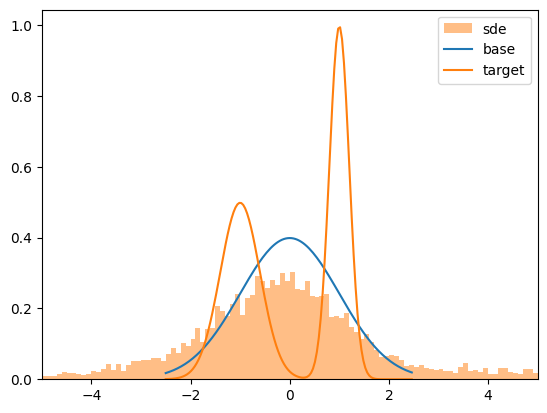

In [ ]:
plt.hist(samples[:,-1], 100, density=True, range=[-5,5], label='sde', alpha=0.5, color='C1');
plt.plot(x, base.prob(x), color='C0', label='base');
plt.plot(x, target.prob(x), color='C1', label='target');
plt.legend();
xlim(-5,5)

Let's take a look at the trajectories

(-4.0, 4.0)

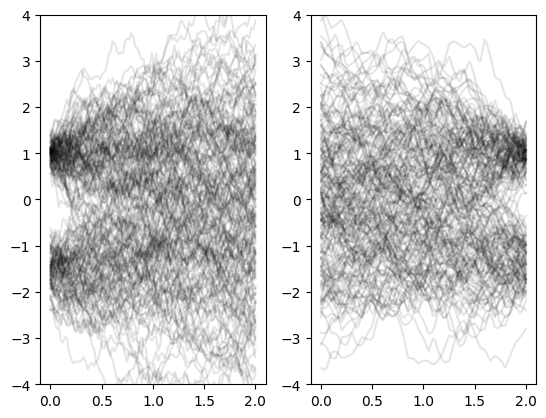

In [ ]:
# Let's take a look at the trajectories

subplot(121)
tts, xs = forward_sde(jax.random.split(jax.random.PRNGKey(0),num_samples), target_samples)
for i in range(200):
  plot(ts[i,:], xs[i,:], alpha=0.1, color='k');
ylim(-4,4)

subplot(122)
for i in range(200):
  plot(ts[i,::-1], samples[i,::-1], alpha=0.1, color='k');
ylim(-4,4)